In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import scipy.sparse
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from R_interop import ZIFA
from R_interop import ZINB
from R_interop import SIMLR

from benchmarking import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_path = "/home/ubuntu/single-cell-scVI/data/10xPBMCs/"

# gene filtering once and for all from original matrix

In [4]:
gene_names = np.array(pd.read_csv(data_path + "michael_gene_names.csv", index_col=0)["x"], dtype=str)

In [5]:
expression = pd.DataFrame(scipy.io.mmread(data_path + "count.mtx").T.A, columns=gene_names)
expression.shape 

(12039, 22156)

#### select genes that are in the DE data

In [6]:
def dumb_prefix(x, n):
    if x != "GS":
        return str(n) + "_" + x
    else:
        return x

In [7]:
# load micro_array data and align existing genes
exp_data_1 = pd.read_csv(data_path+"gene_data/GSE8835_CD4_CD8.tab", delimiter="\t")
exp_data_1["GS"] = exp_data_1.index
exp_data_1.columns = [dumb_prefix(x, "CD") for x in exp_data_1.columns] 
exp_data_2 = pd.read_csv(data_path+"gene_data/GSE29618_Bcells_mDC.tab", delimiter="\t")
exp_data_2["GS"] = exp_data_2.index
exp_data_2.columns = [dumb_prefix(x, "BDC") for x in exp_data_2.columns]
exp_data_3 = pd.read_csv(data_path+"gene_data/GSE22886_Bcells_mDC.tab", delimiter="\t")
exp_data_3["GS"] = exp_data_3.index
exp_data_3.columns = [dumb_prefix(x, "BDC2") for x in exp_data_3.columns]
exp_data = pd.merge(exp_data_1, \
                          exp_data_2, how="inner", on="GS")
exp_data = pd.merge(exp_data, \
                          exp_data_3, how="inner", on="GS")
exp_data.shape

(6394, 19)

In [8]:
# order correspondance from datasets
gene_dataset_name = pd.DataFrame(gene_names, columns=["ENSG"])
gene_correspondance = pd.read_csv(data_path+"de/new_rownames.tab", delimiter="\t")
gene_correspondance.columns = ["ENSG", "GS"]
ordered_corres = pd.merge(gene_dataset_name, \
                          gene_correspondance, how="inner", on="ENSG", left_index=True)

In [9]:
micro_array_result = pd.merge(ordered_corres, exp_data, how="inner", on="GS", right_index=True)
micro_array_result.shape

(3346, 20)

In [10]:
micro_array_result.to_csv(data_path+"de/gene_info.csv")

In [11]:
expression = expression[micro_array_result["ENSG"]]

In [12]:
de_expression = np.copy(expression.as_matrix())
de_gene_names = expression.columns

In [138]:
np.savetxt(data_path+"gene_data/gene_names.tab", gene_names, fmt='%s')

## now clusters and qc

In [13]:
design = pd.read_csv(data_path + "design.csv", index_col=0)
dim_names = ["WPC"+str(i) for i in range(1, 8)]
qc_pc = design[dim_names].as_matrix()
normalized_qc = pd.read_csv(data_path + "full_qc.csv", index_col=0)
barcodes = pd.read_csv(data_path + "barcodes.csv", index_col=1)
batch = pd.read_csv(data_path + "batch.csv", index_col=0)

In [14]:
raw_qc_8 = pd.read_csv(data_path + "molecule_qc_8k.txt", index_col=0, sep="\t")
raw_qc_8.index = raw_qc_8.index.map(lambda s: s+"-1")
raw_qc_4 = pd.read_csv(data_path + "molecule_qc_4k.txt", index_col=0, sep="\t")
raw_qc_8 = raw_qc_8.loc[barcodes.iloc[np.where(batch["x"] == "pbmc8k")[0], :].index.values]
number_suffix = barcodes.iloc[np.where(batch["x"] == "pbmc4k")[0], :].index.map(lambda s: str(s.split("-")[1])).values
barcode_prefix = barcodes.iloc[np.where(batch["x"] == "pbmc4k")[0], :].index.map(lambda s: str(s.split("-")[0])).values
raw_qc_4 = raw_qc_4.loc[barcode_prefix]
raw_qc_4.index = raw_qc_4.index +"-" +number_suffix

In [15]:
raw_qc = pd.concat((raw_qc_8, raw_qc_4)).loc[barcodes.index]

In [16]:
qc_pc.shape, normalized_qc.shape, raw_qc.shape, batch.shape

((12039, 7), (12039, 9), (12039, 9), (12039, 1))

In [17]:
bio = pd.read_csv(data_path + "bio.csv", index_col=0)
list_clusters = np.unique(bio["x"])
def string_to_cluster(string):
    return np.where(list_clusters == string)[0][0]
data_bio = bio["x"].apply(lambda i: string_to_cluster(i))
clusters = data_bio.values
counts = data_bio.value_counts()[range(0, 9)].values
print "dataset_population"
zip(list(np.unique(clusters)), list(list_clusters), list(counts))

dataset_population


[(0, 'B cells', 1625),
 (1, 'CD14+ Monocytes', 2237),
 (2, 'CD4 T cells', 5024),
 (3, 'CD8 T cells', 1452),
 (4, 'Dendritic Cells', 339),
 (5, 'FCGR3A+ Monocytes', 351),
 (6, 'Megakaryocytes', 88),
 (7, 'NK cells', 459),
 (8, 'Other', 464)]

In [18]:
_, batch = np.unique(batch, return_inverse=True)

In [19]:
X_train, X_test, \
de_X_train, de_X_test, \
c_train, c_test, \
r_train, r_test, \
b_train, b_test, \
qc_train, qc_test = \
                train_test_split(expression, de_expression, clusters, qc_pc, \
                                 batch, raw_qc.as_matrix(), random_state=0)

In [31]:
scipy.sparse.save_npz(data_path + "data_train.npz", scipy.sparse.coo_matrix(X_train))
scipy.sparse.save_npz(data_path + "data_test.npz", scipy.sparse.coo_matrix(X_test))

np.save(data_path + "de/data_train", de_X_train)
np.save(data_path + "de/data_test", de_X_test)

np.savetxt(data_path + "label_train", c_train)
np.savetxt(data_path + "label_test", c_test)

np.savetxt(data_path + "b_train", b_train)
np.savetxt(data_path + "b_test", b_test)

np.save(data_path + "design_train", r_train)
np.save(data_path + "design_test", r_test)

np.save(data_path + "qc_train", qc_train)
np.save(data_path + "qc_test", qc_test)

# Now benchmarking

In [20]:
n_latent = 10

In [21]:
#X_train = scipy.sparse.load_npz(data_path + "data_train.npz").A
#X_test = scipy.sparse.load_npz(data_path + "data_test.npz").A
X_train = np.load(data_path + "de/data_train.npy")
X_test = np.load(data_path + "de/data_test.npy")
r_train = np.load(data_path + "design_train.npy")
r_test = np.load(data_path + "design_test.npy")
c_train = np.loadtxt(data_path + "label_train")
c_test = np.loadtxt(data_path + "label_test")
b_train = np.loadtxt(data_path + "b_train")
b_test = np.loadtxt(data_path + "b_test")

In [22]:
algorithms = [PCA(n_components=n_latent, svd_solver="full"), \
              ZIFA.ZIFA(n_components=n_latent)]
alg_names = ["PPCA", "ZIFA"]
alg_logs = [True, True, False]

In [23]:
for i, alg in enumerate(algorithms):
    print i, alg_names[i]
    
    if i == 1:
        #ZIFA do not converge in reasonable time
        continue
    
    data_train = X_train
    data_test = X_test
    
    if alg_logs:
        data_train = np.log(1 + X_train)
        data_test = np.log(1 + X_test)
        
    %time alg.fit(data_train)
    latent = alg.transform(data_train)
    
    print cluster_scores(latent, 9, c_train)
    print entropy_batch_mixing(latent, b_train)
    
    score = alg.score(data_test)
    if alg_logs:
        score -= np.mean(np.sum(data_test, axis=-1))
        
    print score

0 PPCA
CPU times: user 1min 52s, sys: 8.6 s, total: 2min 1s
Wall time: 31.8 s
[0.32141702134965328, 0.68377188523709931, 0.54595098016588517]
0.616187184275
-411.634143765
1 ZIFA


In [9]:
# ZINB crashes
# zinb = ZINB.ZINB(n_components=n_latent, learn_V=True)
# % time zinb.fit(X_train)
# % time latent = zinb.transform(X_train)
# print zinb.score(X_test)
# print cluster_scores(latent, 9, c_train)

In [36]:
simlr = SIMLR(n_clusters=9)
%time simlr.fit_transform(X_train)
clear_output()
print cluster_scores(simlr.F, 9, c_train)
print entropy_batch_mixing(simlr.F, b_train)

[0.78212435541262204, 0.83751868977433352, 0.88378315126477902]
0.628411486367


## imputation

In [5]:
X_zero, i, j, ix = dropout(X_train)
np.save(data_path + "imputation/X_zero.npy", X_zero)
np.save(data_path + "imputation/i.npy", i)
np.save(data_path + "imputation/j.npy", j)
np.save(data_path + "imputation/ix.npy", ix)

In [24]:
X_zero, i, j, ix = \
        np.load(data_path + "imputation/X_zero.npy"),\
        np.load(data_path + "imputation/i.npy"), \
        np.load(data_path + "imputation/j.npy"), \
        np.load(data_path + "imputation/ix.npy")

In [ ]:
# ZIFA Imputation
zifa = ZIFA(n_components=10)
%time zifa.fit(np.log(1 + X_zero))
%time X_ZIFA_log = zifa.output_estimation(np.log(1 + X_zero))["EX"]
p_ZIFA = np.exp(- zifa.params["decay_coef"] * X_ZIFA_log**2)
print("ZIFA", imputation_error(np.exp(X_ZIFA_log) - 1, X_train, i, j, ix), \
              imputation_dropout(np.log(p_ZIFA), X_zero, i, j, ix))
del X_ZIFA_log
del p_ZIFA

In [ ]:
# ZINB Imputation
zinb = ZINB(n_components=10)
%time zinb.fit(X_zero)
%time zinb.score(X_zero)
fit_ZINB = zinb.output_estimation()
def softplus(x):
    return np.log(1 + np.exp(x))
X_ZINB = fit_ZINB[0]
logit_ZINB = fit_ZINB[1]
theta_ZINB = fit_ZINB[2]
log_pi_ZINB = -softplus(- logit_ZINB)
log_p_ZINB = softplus(- logit_ZINB + theta_ZINB * np.log(theta_ZINB + 1e-8) \
                      - theta_ZINB * np.log(theta_ZINB + X_ZINB + 1e-8)) -  softplus( - logit_ZINB)
print("ZINB", imputation_error(X_ZINB, X_train, i, j, ix),\
      imputation_dropout(log_pi_ZINB, X_zero, i, j, ix), imputation_dropout(log_p_ZINB, X_zero, i, j, ix))
del fit_ZINB

In [13]:
#MAGIC Imputation
mean_MAGIC = np.load(data_path + "imputation/X_zero_MAGIC.npy")
print("MAGIC", imputation_error(mean_MAGIC, X_train, X_zero, i, j, ix))

('MAGIC', 0.60782387893793932)


# de benchmark

In [25]:
from R_interop import IDR, deseq, mast, edgeR

In [26]:
micro_array_result = pd.read_csv(data_path+"de/gene_info.csv")

In [27]:
micro_array_result.head()

,Unnamed: 0,ENSG,GS,CD_logFC,CD_AveExpr,CD_t,CD_P.Value,CD_adj.P.Val,CD_B,BDC_logFC,...,BDC_t,BDC_P.Value,BDC_adj.P.Val,BDC_B,BDC2_logFC,BDC2_AveExpr,BDC2_t,BDC2_P.Value,BDC2_adj.P.Val,BDC2_B
0,5,ENSG00000188976,NOC2L,0.248976,4.193230,1.308282,0.201059,0.478547,-5.465606,0.023141,...,0.199196,0.844018,0.936848,-6.964569,0.532702,5.985696,1.671825,0.116222,0.148453,-6.166109
1,7,ENSG00000187608,ISG15,-0.036463,5.769094,-0.216990,0.829737,0.919775,-6.272810,0.987879,...,3.449654,0.002391,0.019573,-2.095965,0.933572,6.303954,2.202136,0.044485,0.062851,-5.300666
2,36,ENSG00000149527,PLCH2,0.505600,3.225463,1.834575,0.076854,0.327638,-4.707168,-0.119499,...,-1.014781,0.321715,0.598441,-6.463128,-0.977612,4.232389,-3.119639,0.007349,0.012455,-3.569136
3,37,ENSG00000157881,PANK4,-0.093142,4.319701,-0.772409,0.446126,0.686981,-6.001137,0.024259,...,0.111785,0.912052,0.963969,-6.978668,0.183735,6.453772,1.306024,0.212100,0.252955,-6.668252
4,40,ENSG00000157873,TNFRSF14,0.073292,4.949553,0.353608,0.726192,0.865967,-6.233949,-0.377352,...,-2.465162,0.022361,0.106855,-4.215261,-0.075492,6.920026,-0.540324,0.597263,0.639609,-7.373536


In [28]:
def boostrap_scores_de(p_value, model, it, p_prior = 0.1, rank_auc=111):
    l = []
    for i in range(it):
        print i
        model_p_value = model.fit().astype(np.float64)
        res = idr.fit(-np.log(model_p_value), -np.log(p_value), p_prior=p_prior)
        auc = auc_score_threshold(p_value, model_p_value, rank_auc, p_value=True)
        res = list(res)
        res.append([auc])
        l.append([x[0] for x in res])    
    return l

In [29]:
gene_names = micro_array_result["ENSG"]
gene_symbols = micro_array_result["GS"]

In [30]:
# interest = "CD"
# couple_celltypes = (3, 2)
# rank_auc = 111
# p_prior = 0.03

interest = "BDC"
couple_celltypes = (0, 4)
rank_auc = 800
p_prior = 0.25

# getting p_values
p_value = micro_array_result[interest + "_adj.P.Val"].values
signed_p_value = - np.log10(p_value) * np.sign(micro_array_result[interest + "_logFC"].values)

In [36]:
idr = IDR.IDR()
deseq_2 = deseq.DESeq2(100, 100, \
                 data_path + "de/data_train.npy",\
                 data_path + "label_train", \
                    couple_celltypes)
mast_ = mast.MAST(100, 100, \
                 data_path + "de/data_train.npy",\
                 data_path + "label_train", \
                    couple_celltypes)

edger_ = edgeR.edgeR(100, 100, data_path + "de/data_train.npy",\
                 data_path + "label_train", \
                    couple_celltypes) 

In [37]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats = importr('stats')

/home/ubuntu/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


BDC_Detected  1742  genes with MAST
BDC_Detected  879  genes with microarray


/home/ubuntu/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/home/ubuntu/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sign
  if __name__ == '__main__':
/home/ubuntu/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/home/ubuntu/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less_equal


BDC_Detected  367  genes with DESeq
BDC_Detected  879  genes with microarray


/home/ubuntu/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


BDC_Detected  1163  genes with edgeR
BDC_Detected  879  genes with microarray


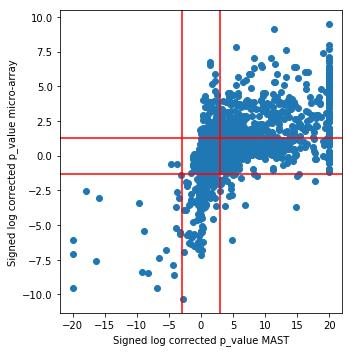

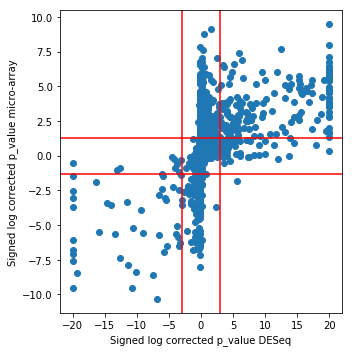

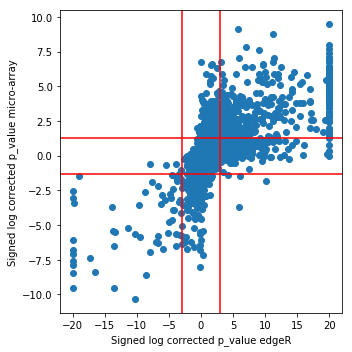

In [39]:
alg_list = ["MAST", "DESeq", "edgeR"]
estim_list = [mast_, deseq_2, edger_]
for t in range(3):
    alg = alg_list[t]
    estim = estim_list[t]
    p, fc = estim.fit(return_fc=True)

    p = np.array(stats.p_adjust(FloatVector(p), method = 'BH'))
    signed_p = - np.log10(p) * np.sign(fc)

    signed_p[signed_p >= 20] = 20
    signed_p[signed_p <= -20] = -20

    plt.figure(figsize=(5, 5))
    plt.scatter(signed_p, signed_p_value)
    plt.axvline(x=3, c="r")
    plt.axvline(x=-3, c="r")
    plt.axhline(y=np.log10(0.05), c="r")
    plt.axhline(y=-np.log10(0.05), c="r")
    plt.xlabel("Signed log corrected p_value "+alg)
    plt.ylabel("Signed log corrected p_value micro-array")
    plt.tight_layout()
    #plt.savefig(interest + "_"+ alg + "_vs_micro_array.pdf", dpi=300)
    print interest + "_" + "Detected ", np.sum(p <= 0.05), " genes with " + alg
    print interest + "_" + "Detected ", np.sum(p_value <= 0.05), " genes with microarray"

In [39]:
boostrap_scores_de(p_value, edger_, 20, p_prior=p_prior, rank_auc=rank_auc)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


[[0.073530264912539028, 0.76195418663262859, 0.77699152011362205],
 [0.068250986446227457, 0.76407072488814065, 0.75826893353941272],
 [0.077765533677118415, 0.77260147889449005, 0.7276271634849687],
 [0.06571610300534475, 0.74687195787500604, 0.72894300792291511],
 [0.066476238389557463, 0.81145682788121143, 0.72523775707701532],
 [0.073137387809561, 0.73231267047962778, 0.75063842822729998],
 [0.067199978491508036, 0.82443267559563582, 0.7312196276647589],
 [0.076060841551785857, 0.73331833113736489, 0.74386148126488161],
 [0.066649895844789767, 0.7419593462360633, 0.75332442179428261],
 [0.070325053965708775, 0.75922082702337057, 0.70693150646782799],
 [0.070269363881499861, 0.77580140511537032, 0.75295125109653716],
 [0.066838485681943213, 0.78232651181128521, 0.73260509350153857],
 [0.072138465222251119, 0.75967116402180879, 0.72413077683556826],
 [0.070912261946707938, 0.77283260186826508, 0.7374312488686523],
 [0.077054115195049844, 0.76841790311523128, 0.76475486305470852],
 [0

##### deseq

In [40]:
boostrap_scores_de(p_value, deseq_2, 20, p_prior=p_prior, rank_auc=rank_auc)

0


/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


[[0.032902867101084761, 0.75064093569227797, 0.52526938374252241],
 [0.036789116382926083, 0.72017810096583035, 0.5179735461816265],
 [0.056749138334733717, 0.56656014843078162, 0.52498740987703107],
 [0.053730686712023967, 0.53090684455984949, 0.5306070519810977],
 [0.039129326918783583, 0.67061776463314104, 0.56007875281260056],
 [0.034052745141134398, 0.69409934011357677, 0.52993442061155505],
 [0.053500138973116597, 0.60034740095641459, 0.52857115763920492],
 [0.036578018526089592, 0.71090287459174029, 0.52722321624760649],
 [0.033767152313007941, 0.70978620792624969, 0.51776167095316028],
 [0.037461152311075947, 0.70510829261397867, 0.52464612260895827],
 [0.032786172923720942, 0.71062023825762077, 0.53715575721464059],
 [0.036776903122752322, 0.69476703943609541, 0.50803282689608897],
 [0.031149835542971429, 0.73337895785256335, 0.51878387978316931],
 [0.031469050849262284, 0.76241826912790078, 0.52070611885915308],
 [0.032477264713363083, 0.76937458923521596, 0.53382288143281109

##### MAST

In [41]:
boostrap_scores_de(p_value, mast_, 20, p_prior=p_prior, rank_auc=rank_auc)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


[[0.065781157888356173, 0.76990326605871884, 0.7609410028266288],
 [0.062784048122332473, 0.80917994940195381, 0.71204310957015748],
 [0.063971421212487903, 0.77001789394647091, 0.72957517022432006],
 [0.060448377538310706, 0.8125881475527672, 0.72636840859406548],
 [0.066768861752931272, 0.7854925099161234, 0.70587186877758745],
 [0.063340469095832436, 0.81813090452909309, 0.72191960120862753],
 [0.061036225462394837, 0.82093187501924691, 0.75659941239539386],
 [0.070572252155508608, 0.77022310055222787, 0.74184663798265049],
 [0.063235704755484873, 0.81860553895462995, 0.72209226227773371],
 [0.066928372070680031, 0.82596621361863576, 0.72422685436595791],
 [0.07967038190921473, 0.79923288463129472, 0.7388919058161717],
 [0.063989746041377762, 0.78559024397455945, 0.72696993747998384],
 [0.067434143767636387, 0.75430709654858719, 0.74708773688680941],
 [0.059395332998462259, 0.71476823798946998, 0.74906916189760087],
 [0.063526875290721915, 0.79988289017266589, 0.75284681899828731],
